<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/4logP_SMILEVAE_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [1]:
!sudo apt-get install software-properties-common
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install gcc-4.9
!sudo apt-get upgrade libstdc++6
# !pip install keras==2.2.4
%tensorflow_version 1.x
import keras
import tensorflow as tf
print("Keras: %s"%keras.__version__)
print("Tensorflow: %s"%tf.__version__)

!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# RDKIT Imports
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# FOR VAE Architecture 
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
print("RDKit: %s"%rdkit.__version__)

from rdkit import RDLogger  

# Checking if GPU is enabled or not
tf.test.gpu_device_name()



Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learnin

# **Data Fetching**

In [16]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')
WEIGHTS_FOLDER = 'sample_data/weights/'
import csv
smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/SMILEWithProp.csv'      #"sample_data/SMILEWithoutProp.csv"
df = pd.read_csv(smifile, delimiter = ",", header='infer', encoding='utf-8')
# smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/AAAA.smi'      
# df = pd.read_csv(smifile, delimiter = " ", header='infer', encoding='utf-8')
df.smiles = df.smiles.replace('\n','', regex=True)
data= pd.DataFrame(df[df['smiles'].str.len()<60])
data=data.reset_index(drop=True)
NUM_SMILES = len(data)
print("\nSmiles having Length less than Sixty is", NUM_SMILES)
data.head()


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).

Smiles having Length less than Sixty is 7732


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [18]:
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print("Training data shape", smiles_train.shape)
print("Testing Data shape", smiles_test.shape)
print("Total Data Points", NUM_SMILES)
logP_train = smiles_train['logP']
logP_test = smiles_test['logP']

# qed_train=smiles_train['qed']
# qed_test=smiles_test['qed']

# SAS_train=smiles_train['SAS']
# SAS_test=smiles_test['SAS']

train=np.array([logP_train])   #logP_train, qed_train, SAS_train
test= np.array([logP_test])             #logP_test, qed_test, SAS_test
y_train_property=train.transpose()
y_test_property=test.transpose()
#Labels for the Smiles String. We will deal with three properties values.
print("Training Data Property shape", y_train_property.shape)
print("Testing Data Property Shape", y_test_property.shape)


Training data shape (6185, 4)
Testing Data shape (1547, 4)
Total Data Points 7732
Training Data Property shape (6185, 1)
Testing Data Property Shape (1547, 1)


### **Vector Representation of Data**

In [21]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(int_to_char)
print(len(charset), embed)
# print(embed)
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        # print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)
print("Vectorised shape of Training Input", X_train.shape)
print("Vectorised shape of Testing Input",X_test.shape)

{0: 'C', 1: 'N', 2: '/', 3: '(', 4: ']', 5: 'l', 6: 'O', 7: '#', 8: 'B', 9: 'r', 10: '5', 11: '1', 12: '=', 13: ')', 14: 'I', 15: 'F', 16: '2', 17: 'E', 18: '-', 19: '!', 20: 'S', 21: 's', 22: '+', 23: '4', 24: 'o', 25: 'H', 26: 'c', 27: 'P', 28: '[', 29: '\\', 30: '@', 31: 'n', 32: '3'}
33 61
Vectorised shape of Training Input (6185, 61, 33)
Vectorised shape of Testing Input (1547, 61, 33)


### **Checking if Vectorization works!!**

Molecule Index= 500 	Length = 39 	Smile= CN(CC1CCCC1)C(=O)C(=O)Nc1cccc(SC(F)F)c1


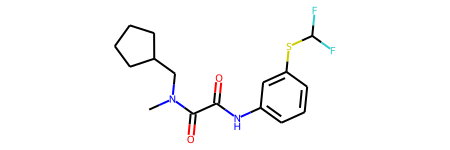

In [22]:
idx=500
print("Molecule Index=", idx,"\tLength =",len(smiles_train['smiles'][idx]),"\tSmile=", (smiles_train['smiles'][idx]))
mol = Chem.MolFromSmiles(smiles_train['smiles'][idx])
mol

39
CN(CC1CCCC1)C(=O)C(=O)Nc1cccc(SC(F)F)c1


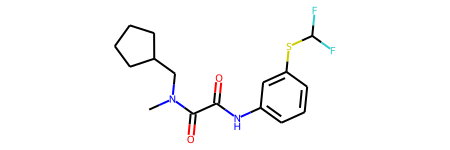

In [23]:
# Going back from vectorized form back to a readable string
smi="".join([int_to_char[idx] for idx in np.argmax(X_train[idx,:,:], axis=1)])
# String After Tructation of extra symbols
smi = re.sub('[!E]', '', smi)
print(len(smi))
print(smi)
mol = Chem.MolFromSmiles(smi)
mol

In [24]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print("Input dimension", orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])

Input dimension 2013


# **VAE**

In [25]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=50# Dimension of the latent vector (z)
epochs=50
pre_trained=False

### **Encoder**

In [26]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu', name='hidden')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer in the model
  encoder_output = Lambda(sampling, output_shape=(2,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')



### **Decoder**

In [27]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu', name='hidden')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')




### **Predictor**

In [28]:
def create_predictor_linear():
    '''
    Creates a regressor that estimates property values 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input', dtype='float32')
    
    x = layers.Dense(10, activation='relu', name='hidden')(predictor_input)
    x = layers.Dense(1, activation='linear', name='predictor_lastlayer', dtype='float32')(x)
    return Model(predictor_input, x, name='predictor')


### **Creating the OverAll Model**

In [29]:
# Model Creation 
def create_model():

  #Creating Encoder
  vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,                                                                                         output_dim = Z_DIM)
# vae_encoder.summary()
  
  
  #Creating Decoder
  vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()

  #Creating the Predictor
  predictor = create_predictor_linear()
  t_predicted = predictor(mean_mu)
  


  #Creating the VAE Model 
  vae_input = vae_encoder_input

  # Output will be the output of the decoder. The term - decoder(encoder_output) 
  vae_output = vae_decoder(vae_encoder_output)

  # # VAE Model with Predictor
  vae_predictor = Model(vae_input, [vae_output,t_predicted], name='VAE_with_Predictor')
# VAE Model without Property Predictor
  # vae_with_predictor = Model(vae_input, vae_output, name='VAE_without_Predictor')



  return vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder, vae_decoder_input, vae_decoder_output, vae_decoder,predictor, vae_input, vae_output, vae_predictor

#Creating the overall Model
encoder_input, encoder_output,  mean_mu, log_var, encoder, decoder_input, decoder_output, decoder, predictor, vae_input, vae_output, vae_predictor = create_model()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### **VAE Loss Function**

In [30]:
#VAE Loss Function
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
  kl_weight=0.5
  reconst_weight=0.5
    
  # vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  vae_loss_val=kl_weight * kl_loss + reconst_weight * reconstruction_loss
  return vae_loss_val


**Plotting all models**

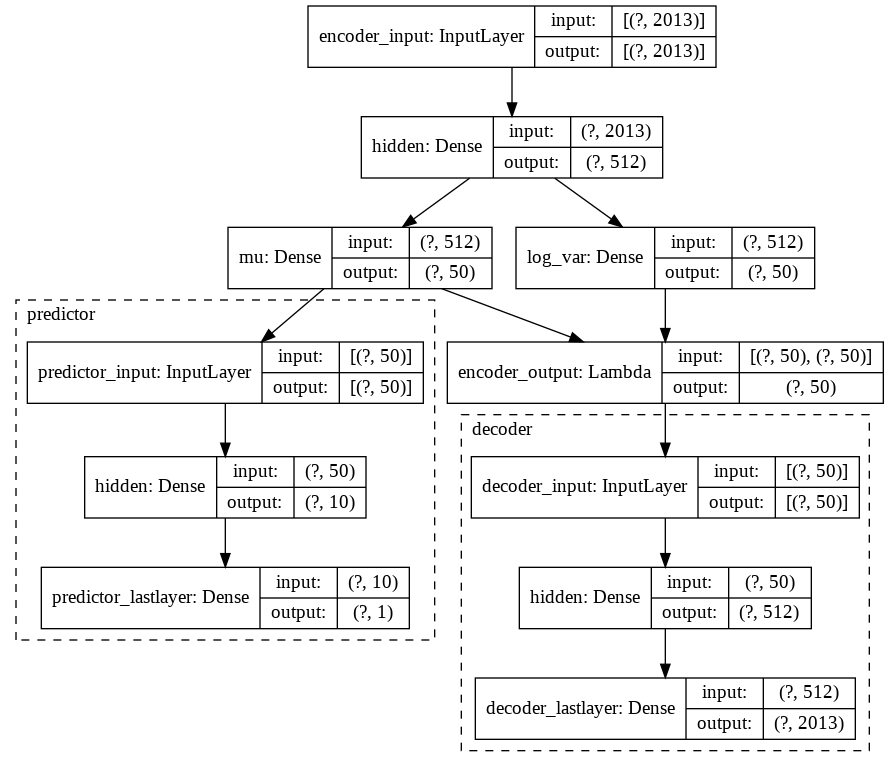

In [99]:
# Plot the Encoder Model
plot_model(encoder, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/only_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

# Plot the Decoder Model
plot_model(decoder, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/only_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# #Plot the Predictor Model
plot_model(predictor, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/only_predictor.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# Plot the VAE-Predictor Model
plot_model(vae_predictor, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/smilesvae_with_logP_predictor.png', show_shapes=True, show_layer_names=True, expand_nested=True)   #, expand_nested=False



**Checkpoint**

In [32]:
# Creating Model Checkpoint for training...

checkpoint_path = "/drive/My Drive/ZINC/Models/OnlylogP/Weights/train_ckpt/cp.ckpt"
new_check_path="/drive/My Drive/ZINC/Models/OnlylogP/Weights/VAE_With_logP_Predictor{epoch:02d}-{val_loss:.2f}.h5"           #'VAE_Predictor{epoch:02d}.h5'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=new_check_path, verbose=1, save_weights_only=False, save_best_only=True)   #, save_freq=5

# Loading weights from the latest checkpoints
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(new_check_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

### **Training or Loading the VAE Model**

In [109]:
pre_trained=False
epochs=100
if __name__ == '__main__':          
#     Train the Variational AutoEncoder
    if pre_trained==False:
      vae_predictor.compile(optimizer='adam', 
                      loss=[vae_loss, 'mean_squared_error'], 
                      loss_weights=[0.25, 0.5]     
                      ) 
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback] )  
      vae_predictor.save(new_check_path)
    else:
      vae_predictor.load_weights(new_check_path)
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback]) 
      vae_predictor.save(new_check_path)
    

Train on 6185 samples, validate on 1547 samples
Epoch 1/100

Epoch 00001: val_loss improved from 41.40352 to 22.24738, saving model to /drive/My Drive/ZINC/Models/OnlylogP/Weights/VAE_With_logP_Predictor01-22.25.h5
6185/6185 - 1s - loss: 9.3445 - decoder_loss: 37.2924 - predictor_loss: 0.0431 - val_loss: 22.2474 - val_decoder_loss: 87.0973 - val_predictor_loss: 0.8440
Epoch 2/100

Epoch 00002: val_loss did not improve from 22.24738
6185/6185 - 1s - loss: 9.2886 - decoder_loss: 37.0630 - predictor_loss: 0.0388 - val_loss: 22.4277 - val_decoder_loss: 87.9999 - val_predictor_loss: 0.8715
Epoch 3/100

Epoch 00003: val_loss did not improve from 22.24738
6185/6185 - 1s - loss: 9.2897 - decoder_loss: 37.0618 - predictor_loss: 0.0431 - val_loss: 22.5043 - val_decoder_loss: 88.2162 - val_predictor_loss: 0.9401
Epoch 4/100

Epoch 00004: val_loss did not improve from 22.24738
6185/6185 - 1s - loss: 9.2730 - decoder_loss: 36.9989 - predictor_loss: 0.0426 - val_loss: 22.5075 - val_decoder_loss: 88.

In [110]:
# print(type(history))
# print(type(history.history))
print(history.history.keys())

dict_keys(['loss', 'decoder_loss', 'predictor_loss', 'val_loss', 'val_decoder_loss', 'val_predictor_loss'])


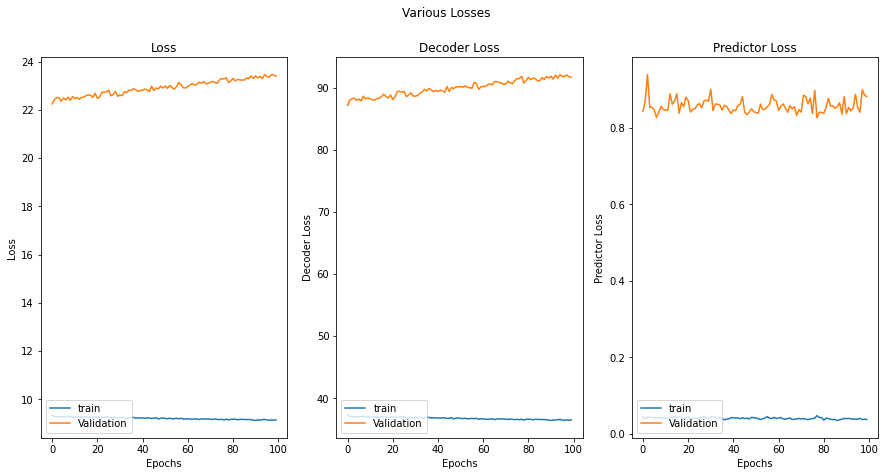

In [120]:
# summarize history for loss
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Various Losses')


ax1.plot(history.history['loss'])
ax1.plot( history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'Validation'], loc='lower left')


ax2.plot(history.history['decoder_loss'])
ax2.plot(history.history['val_decoder_loss'])
ax2.set_title('Decoder Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Decoder Loss')
ax2.legend(['train', 'Validation'], loc='lower left')

ax3.plot(history.history['predictor_loss']) 
ax3.plot(history.history['val_predictor_loss'])
ax3.set_title('Predictor Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Predictor Loss')
ax3.legend(['train', 'Validation'], loc='lower left')

# **Latent Space Visualization**

### **Each Component of latent space**

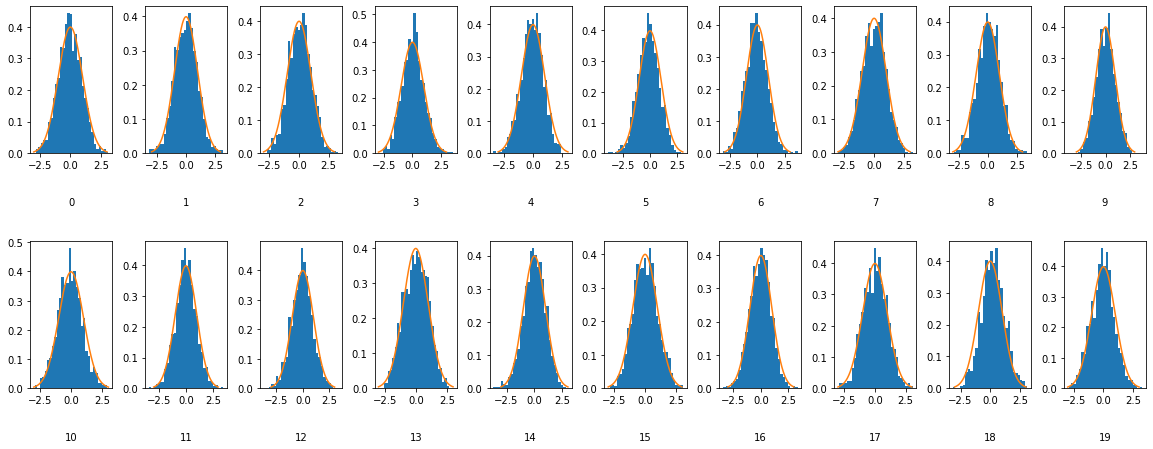

In [121]:
from scipy.stats import norm
# with graph.as_default():   # We are using this statement to reuse the last saved trained model
z_test = encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 30)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

## **Latent Space Values of qed Properties**

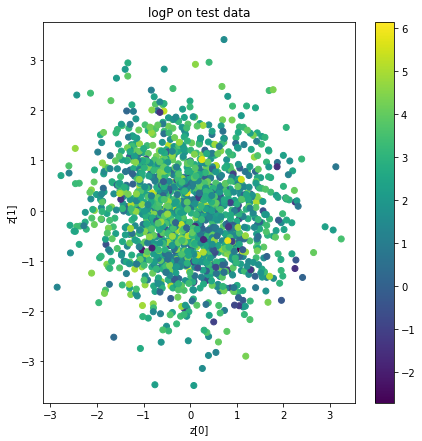

In [122]:
from sklearn.manifold import TSNE
z_mean = encoder.predict(X_test)
# print(z_mean)
model_name='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "VAESMILES_logPLatent_mean.png")

# z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=logP_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('logP on test data')
plt.savefig(filename)
plt.show()

# **Reconstruction On Test Data**


Encoded data shape (1547, 50)
Decoded Test data Shape (1547, 2013)
<class 'numpy.ndarray'>

Original Test Data Dimension (1547, 61, 33)
Reconstructed Test Data Dimension (1547, 61, 33)
1547 Original Valid Test Samples
6 Reconstructed Valid Test Molecules

Molecule 36 Original Valid Molecule COc1ccc(C(=O)N(C)Cc2ccc(N(C)C)cc2)cn1 Original Property= [2.4284]
Molecule 36 Reconstructed Valid molecule COc1ccc(C(=O)NCC)Cc2ccc(O)C(O)ccc2c1 Predicted Property= [-2.4813216]

Molecule 389 Original Valid Molecule CCc1noc(CNc2ccccc2Cc2ccccc2)n1 Original Property= [3.8349]
Molecule 389 Reconstructed Valid molecule CCc1cnc(CCc2ccnnc2-cccccc1) Predicted Property= [-0.51258606]

Molecule 777 Original Valid Molecule CC(=O)Nc1ccc(OCC(=O)N2CCN(C(=O)C3CC3)CC2)cc1 Original Property= [1.1046]
Molecule 777 Reconstructed Valid molecule CC(=O)Nc1ccc(COC(=O)N2CCN(C(=O)NCCCC)CC2)cc1 Predicted Property= [0.8833431]

Molecule 1080 Original Valid Molecule Cc1ccccc1N1C(=O)CNC1=S Original Property= [1.21612]
Molecule 

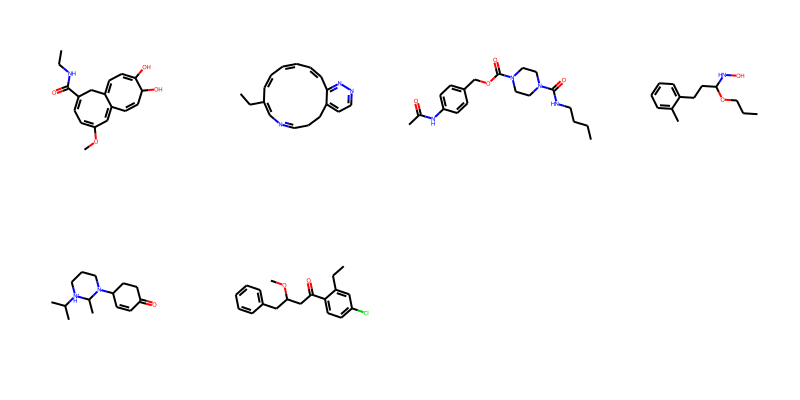

In [123]:
# encoded, decoded and predicted data on test dataset
encoded_xtest=encoder.predict(X_test)
allProp_pred_xtest=predictor.predict(encoded_xtest)
decoded_xtest=decoder.predict(encoded_xtest)
print("Encoded data shape",encoded_xtest.shape)
print("Decoded Test data Shape", decoded_xtest.shape)

allProp_orig_xtest= y_test_property

# print("\nPredicted Property Data Shape",allProp_pred_xtest.shape)
# print("Properties of Test Data Shape", allProp_orig_xtest.shape)
print(type(allProp_orig_xtest))
# Reshaping the original and reconstructed test data
orig_test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
reconst_test = decoded_xtest.reshape(len(X_test), mol_size_x,mol_size_y)

print("\nOriginal Test Data Dimension",orig_test.shape)
print("Reconstructed Test Data Dimension", reconst_test.shape)

### **Original and Reconstructed test data set**
# Going back from vectorized form back to a readable string on original test data
IPythonConsole.ipython_useSVG=True 
mols_orig_test= []
smi_orig_test=[]
syntax_val={0:[], 1:[]}

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_orig_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid SMiles" ,sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
      # print(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


smi_orig_test_valid=[]
mols_orig_test_valid=[]
for item in syntax_val[1]:
  smi_orig_test_valid.append(smi_orig_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
# smi_orig_test_valid


print(len(mols_orig_test_valid), "Original Valid Test Samples")
# Draw.MolsToGridImage(mols_orig_test_valid, molsPerRow=4,subImgSize=(200,200))



### **Reconstruction on test data**


RDLogger.DisableLog('rdApp.*') 
# Going back from vectorized form back to a readable string on original test data
#Reconstruction
syntax_val={0:[], 1:[]}
mols_reconst_test= []
smi_reconst_test=[]

 

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Reconstructed Smile", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=False)
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue


smi_reconst_test_valid=[]
mols_reconst_test_valid=[]
allProp_pred_xtest_valid=[]

smi_orig_test_valid=[]
mols_orig_test_valid=[]
allProp_orig_xtest_valid=[]




print(len(syntax_val[1]), "Reconstructed Valid Test Molecules")
for item in syntax_val[1]:
  smi_reconst_test_valid.append(smi_reconst_test[item])
  smi_orig_test_valid.append(smi_orig_test[item])


  mols_reconst_test_valid.append(mols_reconst_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])

  allProp_pred_xtest_valid.append(allProp_pred_xtest[item])
  allProp_orig_xtest_valid.append(allProp_orig_xtest[item])

  print("\nMolecule", item, "Original Valid Molecule", smi_orig_test[item], "Original Property=", allProp_orig_xtest[item] )
  print("Molecule", item, "Reconstructed Valid molecule", smi_reconst_test[item],"Predicted Property=", allProp_pred_xtest[item] )


Draw.MolsToGridImage(mols_reconst_test_valid, molsPerRow=4,subImgSize=(200,200))



## **Reconstruction on Training data**

Encoded data shape (6185, 50)
Decoded Training data Shape (6185, 2013)
<class 'numpy.ndarray'>

Original Training Data Dimension (6185, 61, 33)
Reconstructed Training Data Dimension (6185, 61, 33)
6185 Original Valid Training Samples
1066 Reconstructed Valid Training Samples

Molecule 6 Original Valid Molecule COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O Original Property= [0.9978]
Molecule 6 Reconstructed Valid molecule COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O Predicted Property= [1.6703355]

Molecule 24 Original Valid Molecule N#Cc1ccncc1NC[C@@H]1C[C@@]12CCc1ccccc12 Original Property= [3.26928]
Molecule 24 Reconstructed Valid molecule N#Cc1ccccc1NC[C@@H]1C[C@@]12CCc1ccccc12 Predicted Property= [1.3594924]

Molecule 26 Original Valid Molecule CNC(=O)c1ccc(/C=C/C(=O)Nc2c(C)cc(C)nc2Cl)cc1 Original Property= [3.36334]
Molecule 26 Reconstructed Valid molecule COC(=O)c1ccc(/C=C/C(=O)Nc2c(C)cc(C)cc2Cl)cc1 Predicted Property= [5.0602655]

Molecule 32 Original Valid Molecule O=C(O[C@H]1CCOC1)C1

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


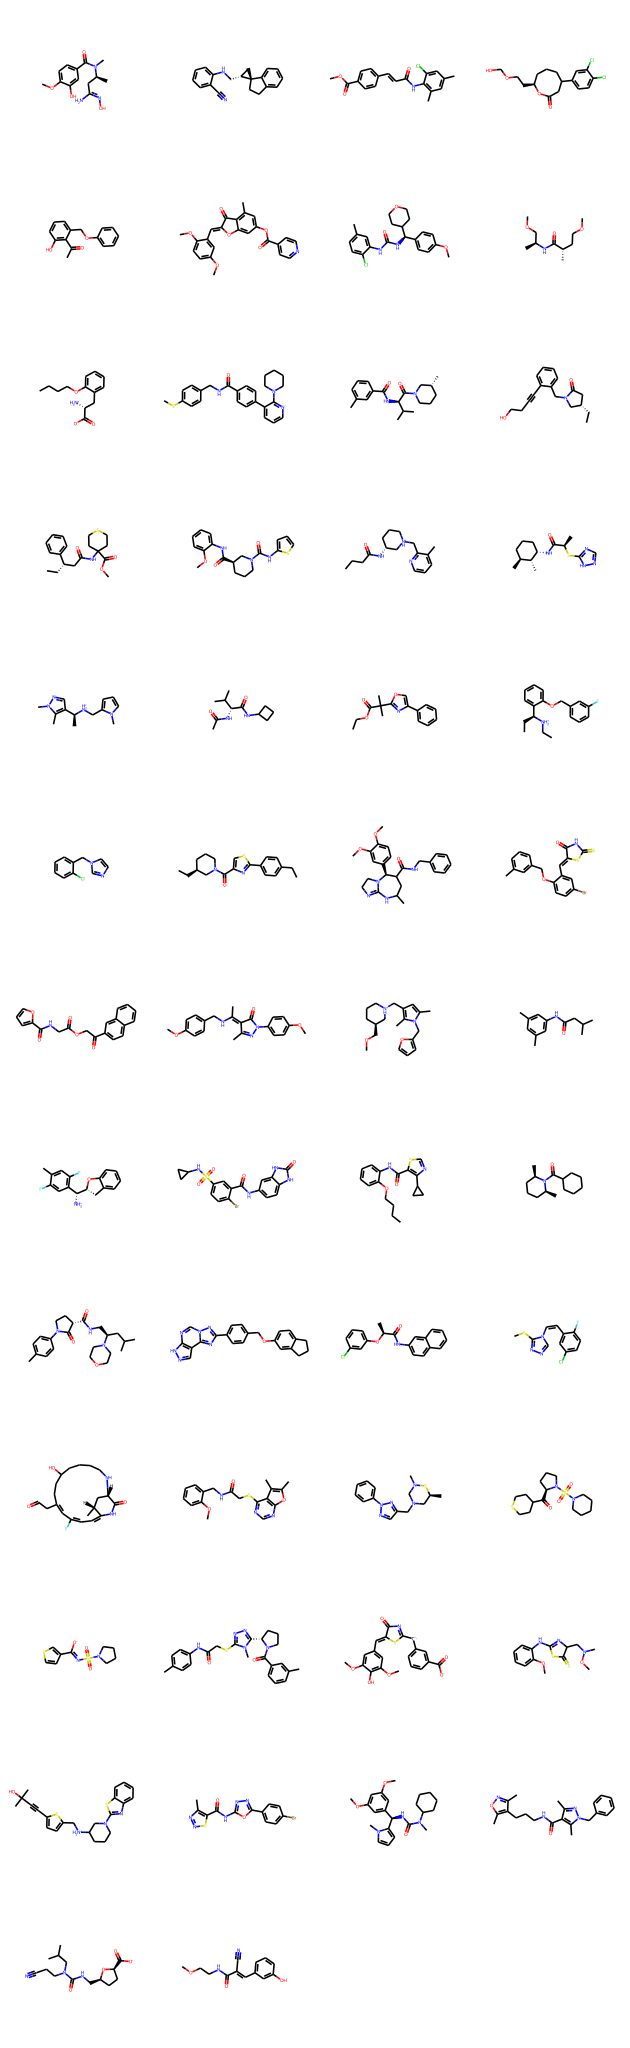

In [124]:
# encoded, decoded and predicted data on Training dataset

# encoded, decoded and predicted data on Training dataset
encoded_xtrain=encoder.predict(X_train)
allProp_pred_xtrain=predictor.predict(encoded_xtrain)
decoded_xtrain=decoder.predict(encoded_xtrain)
print("Encoded data shape",encoded_xtrain.shape)
print("Decoded Training data Shape", decoded_xtrain.shape)

allProp_orig_xtrain= y_train_property

# print("\nPredicted Property Data Shape",allProp_pred_xtrain.shape)
# print("Properties of Training Data Shape", allProp_orig_xtrain.shape)
print(type(allProp_orig_xtrain))
# Reshaping the original and reconstructed training data
orig_train=X_train.reshape(len(X_train), mol_size_x, mol_size_y)
reconst_train = decoded_xtrain.reshape(len(X_train), mol_size_x,mol_size_y)

print("\nOriginal Training Data Dimension",orig_train.shape)
print("Reconstructed Training Data Dimension", reconst_train.shape)


# Going back from vectorized form back to a readable string on original training data

syntax_val={0:[], 1:[]}

smi_orig_train=[]
mols_orig_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_train[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_orig_train.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(mol), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 

smi_orig_train_valid=[]
mols_orig_train_valid=[]

for item in syntax_val[1]:
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))
  mols_orig_train_valid.append(mols_orig_train[item])


print(len(mols_orig_train_valid), "Original Valid Training Samples")
# Draw.MolsToGridImage(mols_orig_train_valid, molsPerRow=4,subImgSize=(200,200))

# Going back from vectorized form back to a readable string on Reconstructed training data
#Reconstruction

syntax_val={0:[], 1:[]}

smi_reconst_train=[]
mols_reconst_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_train[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_train.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=True)      
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue

smi_reconst_train_valid=[]
mols_reconst_train_valid=[]
allProp_pred_xtrain_valid=[]

smi_orig_train_valid=[]
mols_orig_train_valid=[]
allProp_orig_xtrain_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Training Samples")
for item in syntax_val[1]:
  smi_reconst_train_valid.append(smi_reconst_train[item].rstrip('\n'))
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))

  mols_reconst_train_valid.append(mols_reconst_train[item])
  mols_orig_train_valid.append(mols_orig_train[item])

  allProp_pred_xtrain_valid.append(allProp_pred_xtrain[item])
  allProp_orig_xtrain_valid.append(allProp_orig_xtrain[item])

  print("\nMolecule", item, "Original Valid Molecule", smi_orig_train[item], "Original Property=", allProp_orig_xtrain[item] )
  print("Molecule", item, "Reconstructed Valid molecule", smi_reconst_train[item],"Predicted Property=", allProp_pred_xtrain[item] )

Draw.MolsToGridImage(mols_reconst_train_valid, molsPerRow=4,subImgSize=(200,200))



In [125]:
print("Validity Percentage of Training Reconstructed Molecules", (len(mols_reconst_train_valid)/len(mols_reconst_train))*100, "%")
print("Validity Percentage of Testing Reconstructed Molecules", (len(mols_reconst_test_valid)/len(mols_reconst_test))*100,"%")

Validity Percentage of Training Reconstructed Molecules 17.23524656426839 %
Validity Percentage of Testing Reconstructed Molecules 0.3878474466709761 %


# **Generating New Valid Molecules from Normal Distribution**

New valid Molecule 1 CNCCCC(ccccc(Cl)c1)CC(O)cc(C(=O)CCOF)cc1C Index= 2768
New valid Molecule 2 Cc1cccc(C(=O)N(C(=O)CCCCSC(C)CC))ncccc1C Index= 17416
New valid Molecule 3 CCC[C@H](CCNc(=O)N1CCCCCC=O)CCcccccc1C Index= 17682
New valid Molecule 4 Cc1cc(C)cc(NC(=O)NO)(CO)CccccccC1 Index= 30166
New valid Molecule 5 CCc1ccc(c(=O)Nn2CCCC)cccccc12 Index= 32112
New valid Molecule 6 O=C(NC1Ccc2C1)C[C@H]2OC(NC)COCCCCCCCCCC Index= 36255
6 New Valid Molecules


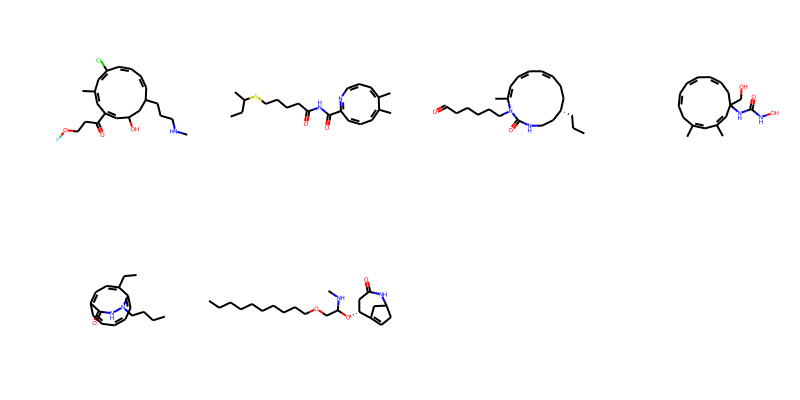

In [143]:
syntax_val_new={0:[], 1:[]}


smi_reconst_new=[]
smi_reconst_new_valid=[]

mols_reconst_new= []
mols_reconst_new_valid=[]

n_mol=50000

latent_samples= np.random.normal(0,1,size=(n_mol,Z_DIM))

#Passing it to Decoder
reconst_sample = decoder.predict(latent_samples)
reconst_smi=reconst_sample.reshape(n_mol, mol_size_x, mol_size_y) 

for id, latent_mol in enumerate(reconst_smi):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_smi[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_reconst_new.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_new.append(mol)
  if mol is None:
    syntax_val_new[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val_new[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid New Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)      
    except:
      print('Mol {} {}'.format(id+1, mol)) 

i=1
for item in syntax_val_new[1]:
  smi_reconst_new_valid.append(smi_reconst_new[item].rstrip('\n'))
  mols_reconst_new_valid.append(mols_reconst_new[item])
  print("New valid Molecule", i, smi_reconst_new[item], "Index=", item)
  i=i+1

print(len(mols_reconst_new_valid), "New Valid Molecules")
Draw.MolsToGridImage(mols_reconst_new_valid, molsPerRow=4,subImgSize=(200,200))


# **Property Acceptance of Newly Generated Valid Molecules**

In [144]:
# Calculating mean and standard deviation of all property values on test data

logP_mean_test= np.mean(y_test_property, axis=0)
logP_std_test = np.std(y_test_property, axis=0)
print("logP Property Value Range = ", logP_mean_test,"+-", logP_std_test )

# Predicting Properties of New Valid Molecules

if len(syntax_val_new[1])!=0:
  predicted_prop_samples=predictor.predict(latent_samples[syntax_val_new[1]])
  for ((id,item), val_mol_id) in zip(enumerate(predicted_prop_samples), syntax_val_new[1]):
    # print(id)
    a=predicted_prop_samples[id][0]<(logP_mean_test+logP_std_test)
    b=predicted_prop_samples[id][0]>=(logP_mean_test-logP_std_test)
    print("logP Predicted Properties of molecule having index ", val_mol_id,"is", predicted_prop_samples[id])
    if (a & b):
      print("Mol having index {}, Property Validated".format(val_mol_id))    
    else:    
      print("Mol having index {}, Property Invalidated".format(val_mol_id)) 
else:
  print("No Valid Molecule Generated")  

logP Property Value Range =  [2.46545235] +- [1.43971021]
logP Predicted Properties of molecule having index  2768 is [1.0817086]
Mol having index 2768, Property Validated
logP Predicted Properties of molecule having index  17416 is [16.419853]
Mol having index 17416, Property Invalidated
logP Predicted Properties of molecule having index  17682 is [0.33486468]
Mol having index 17682, Property Invalidated
logP Predicted Properties of molecule having index  30166 is [-1.5433223]
Mol having index 30166, Property Invalidated
logP Predicted Properties of molecule having index  32112 is [2.6931202]
Mol having index 32112, Property Validated
logP Predicted Properties of molecule having index  36255 is [-1.5888252]
Mol having index 36255, Property Invalidated


In [145]:
# print(syntax_val_new[1])
# print(predicted_prop_samples.shape)
# print(predicted_prop_samples)
# print(type(predicted_prop_samples))
